<a href="https://colab.research.google.com/github/RGIS-Y/RS/blob/main/TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jSeS16o24mf-jLxRvaUQU6M3YM4IqfWPVVAkNirDwGM&tc=5ThsjSj8XWmWjzuHtvTkznviPeKkWT611WfE3ImjRPU&cc=3kBseCOv7tf1yxpB-9QbVGx87204G03gXPcAt01qBqE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvue5fzPEn0lkxPxR4OAWbycxiA0qOpUsJWds4VGnslVDcGustXHfBA

Successfully saved authorization token.


In [ ]:
import tensorflow as tf
import folium
from tensorflow import keras

In [ ]:
Qinghaihu = ee.FeatureCollection("users/20656YJX/FENKUAI/region")
region = Qinghaihu.geometry()

In [ ]:
# Your Earth Engine username.  This is used to import a classified image
# into your Earth Engine assets folder.
USER_NAME = 'yjx9124'
# Use Landsat 8 surface reflectance data for predictors.
# Cloud masking function.
def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])
def addIndices(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi'])
  ndvire2 = image.normalizedDifference(['B8A', 'B6']).rename(['ndvire2'])
  return image.addBands(ndvi.rename("NDVI")).addBands(ndvire2.rename("NDVIRE2"))
# The image input data is a 2018 cloud-masked median composite.
S2 = ee.ImageCollection('COPERNICUS/S2').filterDate('2021-07-01', '2021-08-31').map(maskS2clouds).map(addIndices).median().clip(region)
# S22 = ee.ImageCollection('COPERNICUS/S2').filterDate('2021-07-22', '2021-08-31').map(maskS2clouds).median()
collection_S1=ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
collection_S1_IW=collection_S1 \
.filterMetadata('instrumentMode','equals','IW') \
.filterDate('2021-07-01', '2021-08-31')
Sentinel_1=collection_S1_IW.median().clip(region)
# collection_S11=ee.ImageCollection('COPERNICUS/S1_GRD') \
# .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
# .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
# collection_S1_IW1=collection_S11 \
# .filterMetadata('instrumentMode','equals','IW') \
# .filterDate('2021-07-22', '2021-08-31')

In [ ]:
# Sentinel_11=collection_S1_IW1.median()
image = ee.Image.cat([Sentinel_1,S2]).float().clip(region)
from pprint import pprint
# pprint(image.getInfo())

In [ ]:
# Use these bands for prediction.
BANDS = ['B8','B4','VV','B3','NDVIRE2','VH','NDVI','B1','B6','B7','B2','B12']

In [ ]:
lindi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_lindi")
caodi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_caodi")
shidi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_shidi")
gengdi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_gengdi")
jiansheyongdi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_jiansheyongdi")
shuiti = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_shuiti")
weiliyongtudi = ee.FeatureCollection("users/20656YJX/RS3/Points2/points_weiliyongtudi")

In [ ]:
def setFeaturePro1(Feature):
  return Feature.set({'landcover': 0})
def setFeaturePro2(Feature):
  return Feature.set({'landcover': 1})
def setFeaturePro3(Feature):
  return Feature.set({'landcover': 2})
def setFeaturePro4(Feature):
  return Feature.set({'landcover': 3})
def setFeaturePro5(Feature):
  return Feature.set({'landcover': 4})
def setFeaturePro6(Feature):
  return Feature.set({'landcover': 5})
def setFeaturePro7(Feature):
  return Feature.set({'landcover': 6})
lindi = lindi.map(setFeaturePro1);
caodi = caodi.map(setFeaturePro2);
gengdi = gengdi.map(setFeaturePro3);
shidi = shidi.map(setFeaturePro4);
shuiti = shuiti.map(setFeaturePro5);
jiansheyongdi = jiansheyongdi.map(setFeaturePro6);
weiliyongtudi = weiliyongtudi.map(setFeaturePro7);

In [ ]:
# This is a trianing/testing dataset of points with known land cover labels.
LABEL_DATA = ee.FeatureCollection(lindi.merge(caodi).merge(shidi).merge(gengdi).merge(jiansheyongdi).merge(shuiti).merge(weiliyongtudi))

In [ ]:
# The labels, consecutive integer indices starting from zero, are stored in
# this property, set on each point.
LABEL = 'landcover'
# Number of label values, i.e. number of classes in the classification.
N_CLASSES = 7

In [ ]:
# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
# when reading into TensorFlow datasets.
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

In [ ]:
# File names for the training and testing datasets.  These TFRecord files
# will be exported from Earth Engine into the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'Training_demo'
TEST_FILE_PREFIX = 'Testing_demo'
file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = r'/content/drive/MyDrive/TF'
TEST_FILE_PATH = r'/content/drive/MyDrive/TF'

In [ ]:
# File name for the prediction (image) dataset.  The trained model will read
# this dataset and make predictions in each pixel.
IMAGE_FILE_PREFIX = 'Image_pixel_demo_'


In [ ]:
# The output path for the classified image (i.e. predictions) TFRecord file.
OUTPUT_IMAGE_FILE = r'/content/drive/MyDrive/TF/Classified_pixel_demo.TFRecord'
# Export imagery in this region.
EXPORT_REGION = region

In [ ]:
# The name of the Earth Engine asset to be created by importing
# the classified image from the TFRecord file in Cloud Storage.
OUTPUT_ASSET_ID = 'users/' + USER_NAME + '/Classified_pixel_demo'


In [ ]:
# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[37.539295218085485,101.54934612154766])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:

# Sample the image at the points and add a random column.
sample = image.sampleRegions(
  collection=LABEL_DATA, properties=[LABEL], scale=10).randomColumn()

In [ ]:
# Partition the sample approximately 70-30.
training = sample.filter(ee.Filter.lt('random', 0.7))
testing = sample.filter(ee.Filter.gte('random', 0.7))

In [ ]:
from pprint import pprint
# pprint(testing.getInfo())

# Create the tasks.
training_task = ee.batch.Export.table.toDrive(
  collection=training,
  description='Training Export',
  fileNamePrefix=TRAIN_FILE_PREFIX,
  folder='TF',
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

testing_task = ee.batch.Export.table.toDrive(
  collection=testing,
  description='Testing Export',
  fileNamePrefix=TEST_FILE_PREFIX,
  folder='TF',
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

In [ ]:
# Start the tasks.
training_task.start()
testing_task.start()

In [ ]:
# Specify patch and file dimensions.
image_export_options = {
  'patchDimensions': [256, 256],
  'maxFileSize': 1e15,
  'compressed': True
}

# Setup the task.
image_task = ee.batch.Export.image.toDrive(
  image=image,
  description='Image Export',
  fileNamePrefix=IMAGE_FILE_PREFIX,
  folder='TF',
  scale=10,
  fileFormat='TFRecord',
  region=EXPORT_REGION.getInfo()['coordinates'],
  formatOptions=image_export_options,
)


In [ ]:
# Start the task.
image_task.start()

In [ ]:
# Create a dataset from the TFRecord file in Cloud Storage.
train_dataset = tf.data.TFRecordDataset(r'/content/drive/MyDrive/TF/Training_demo.tfrecord.gz', compression_type='GZIP')
# Print the first record to check.
print(iter(train_dataset).next())


# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with names as keys, features as values.
features_dict = dict(zip(FEATURE_NAMES, columns))
pprint(features_dict)

tf.Tensor(b'\n\xdf\x01\n\x0e\n\x02B8\x12\x08\x12\x06\n\x04f\xf7\x84>\n\x0e\n\x02B4\x12\x08\x12\x06\n\x04\x12\xa5\xbd=\n\x0e\n\x02VV\x12\x08\x12\x06\n\x04\x89\xa7z\xc1\n\x0e\n\x02B3\x12\x08\x12\x06\n\x04\xf3\x1f\xd2=\n\x13\n\x07NDVIRE2\x12\x08\x12\x06\n\x04u\xf2\xe5=\n\x0e\n\x02VH\x12\x08\x12\x06\n\x04\xaf}\xa3\xc1\n\x10\n\x04NDVI\x12\x08\x12\x06\n\x04\x8dp\x02?\n\x0e\n\x02B1\x12\x08\x12\x06\n\x04\xf7\xe4\xe1=\n\x0e\n\x02B6\x12\x08\x12\x06\n\x04Ttd>\n\x0e\n\x02B7\x12\x08\x12\x06\n\x04w-\x81>\n\x0e\n\x02B2\x12\x08\x12\x06\n\x04\xa5,\xc3=\n\x0f\n\x03B12\x12\x08\x12\x06\n\x04\x94\xf6\x06>\n\x15\n\tlandcover\x12\x08\x12\x06\n\x04\x00\x00\x00\x00', shape=(), dtype=string)
{'B1': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[1]

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, features_dict)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.int32)
# Map the function over the dataset.
parsed_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=8)

# Print the first parsed record to check.
pprint(iter(parsed_dataset).next())

({'B1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1103], dtype=float32)>,
  'B12': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1318], dtype=float32)>,
  'B2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0953], dtype=float32)>,
  'B3': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1026], dtype=float32)>,
  'B4': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0926], dtype=float32)>,
  'B6': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2231], dtype=float32)>,
  'B7': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2523], dtype=float32)>,
  'B8': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2597], dtype=float32)>,
  'NDVI': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5095299], dtype=float32)>,
  'NDVIRE2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.11227886], dtype=float32)>,
  'VH': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-20.436369], dtype=float32)>,
  'VV': <tf.Tensor: shape=(1,), dty

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  ##表示使用GPU编号为0的GPU进行计算

In [ ]:
from tensorflow import keras

# Add NDVI.
input_dataset = parsed_dataset

# Keras requires inputs as a tuple.  Note that the inputs must be in the
# right shape.  Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.
def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())),
          tf.one_hot(indices=label, depth=N_CLASSES))

# Map the to_tuple function, shuffle and batch.
input_dataset = input_dataset.map(to_tuple).batch(2)
# Define the layers in the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax)
])
from keras import metrics

# ,keras.metrics.Precision(), keras.metrics.Recall()

# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['accuracy'])

In [ ]:
# Fit the model to the training data.
history = model.fit(x=input_dataset,epochs=100)

Epoch 1/100
1539/1539 [==============================] - 6s 4ms/step - loss: 0.1966 - accuracy: 0.3110
Epoch 2/100
1539/1539 [==============================] - 5s 4ms/step - loss: 0.2856 - accuracy: 3.2499e-04
Epoch 3/100
1539/1539 [==============================] - 5s 3ms/step - loss: 0.1763 - accuracy: 0.3832
Epoch 4/100
1539/1539 [==============================] - 7s 4ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 5/100
1539/1539 [==============================] - 6s 4ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 6/100
1539/1539 [==============================] - 6s 4ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 7/100
1539/1539 [==============================] - 5s 3ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 8/100
1539/1539 [==============================] - 5s 3ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 9/100
1539/1539 [==============================] - 6s 4ms/step - loss: 0.1601 - accuracy: 0.4397
Epoch 10/100
1539/1539 [==============================] - 5s 3ms/step

KeyboardInterrupt: ignored

In [ ]:
model.save("/content/drive/MyDrive/TF")

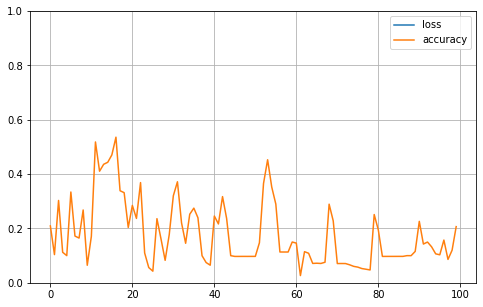

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import pandas as pd
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [ ]:
# reconstructed_model = keras.models.load_model("/content/drive/MyDrive/TF") #Model tranfer
test_dataset = (
  tf.data.TFRecordDataset(r'/content/drive/MyDrive/TF/Testing_demo.tfrecord.gz', compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=8)
    .map(to_tuple)
    .batch(1))
model.evaluate(test_dataset)

10676/10676 [==============================] - 19s 2ms/step - loss: 1.9421 - accuracy: 0.1381


[1.9421169757843018, 0.13806669414043427]

In [ ]:
import os
import json
# Get a list of all the files in the tfrecord data folder.
os.chdir(r'/content/drive/MyDrive/TF')
filesList = !ls -1
PredFilesList = [s for s in filesList if IMAGE_FILE_PREFIX in s]
# Get the list of image files and the JSON mixer file.
image_files_list = []
jsonFile = None
for f in PredFilesList:
    if f.endswith('.tfrecord.gz'):
        image_files_list.append(f)
    elif f.endswith('.json'):
        jsonFile = f
image_files_list.sort()
print(jsonFile)

Image_pixel_demo_-mixer.json


In [ ]:
# Load the contents of the mixer file to a JSON object,and obtain the number of patches
jsonText = !cat {jsonFile}
mixer = json.loads(jsonText.nlstr)
patches = mixer['totalPatches']
mixer


{'projection': {'crs': 'EPSG:4326',
  'affine': {'doubleMatrix': [0.00026949458523585647,
    0.0,
    97.81332920593934,
    0.0,
    -0.00026949458523585647,
    38.32024355844214]}},
 'patchDimensions': [256, 256],
 'patchesPerRow': 48,
 'totalPatches': 1392}

In [ ]:
# Get relevant info from the JSON mixer file.
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width * patch_height, 1]

# Note that the tensors are in the shape of a patch, one patch for each band.
image_columns = [
  tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32)
    for k in BANDS
]

In [ ]:
# Parsing dictionary.
image_features_dict = dict(zip(BANDS, image_columns))

# Note that you can make one dataset from many files by specifying a list.
image_dataset = tf.data.TFRecordDataset(image_files_list, compression_type='GZIP')

# Parsing function.
def parse_image(example_proto):
  return tf.io.parse_single_example(example_proto, image_features_dict)

# Parse the data into tensors, one long tensor per patch.
image_dataset = image_dataset.map(parse_image, num_parallel_calls=8)

# Break our long tensors into many little ones.
image_dataset = image_dataset.flat_map(
  lambda features: tf.data.Dataset.from_tensor_slices(features)
)
image_dataset

<FlatMapDataset element_spec={'B1': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B12': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B2': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B6': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B7': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'B8': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'NDVI': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'NDVIRE2': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'VH': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'VV': TensorSpec(shape=(1,), dtype=tf.float32, name=None)}>

In [ ]:
# # Add additional features (NDVI).
# image_dataset = image_dataset.map(
#   # Add NDVI to a feature that doesn't have a label.
#   lambda features: add_NDVI(features, None)[0]
# ).map(
#   # Add NDVIRE1 to a feature that doesn't have a label.
#   lambda features: add_NDVIRE2(features, None)[0]
# )

# Turn the dictionary in each record into a tuple without a label.
image_dataset = image_dataset.map(
  lambda data_dict: (tf.transpose(list(data_dict.values())), )
)

# Turn each patch into a batch.
image_dataset = image_dataset.batch(patch_width * patch_height)

# Run prediction in batches, with as many steps as there are patches.
predictions = model.predict(image_dataset, steps=patches, verbose=1)

# Note that the predictions come as a numpy array.  Check the first one.
print(predictions[0])

print('Writing to file ' + OUTPUT_IMAGE_FILE)

1125/1392 [=======================>......] - ETA: 9:56

In [ ]:
# Instantiate the writer.
writer = tf.io.TFRecordWriter(OUTPUT_IMAGE_FILE)

In [ ]:
# Every patch-worth of predictions we'll dump an example into the output
# file with a single feature that holds our predictions. Since our predictions
# are already in the order of the exported data, the patches we create here
# will also be in the right order.
patch = [[], [], [], [], [], [], [], []]
cur_patch = 1
for prediction in predictions:
  patch[0].append(tf.argmax(prediction, 1))
  patch[1].append(prediction[0][0])
  patch[2].append(prediction[0][1])
  patch[3].append(prediction[0][2])
  patch[4].append(prediction[0][3])
  patch[5].append(prediction[0][4])
  patch[6].append(prediction[0][5])
  patch[7].append(prediction[0][6])
  # Once we've seen a patches-worth of class_ids...
  if (len(patch[0]) == patch_width * patch_height):
    print('Done with patch ' + str(cur_patch) + ' of ' + str(patches) + '...')
    # Create an example
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'prediction': tf.train.Feature(
              int64_list=tf.train.Int64List(
                  value=patch[0])),
          'LD': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[0])),
          'CD': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[1])),
          'GD': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[2])),
          'SD': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[3])),
          'ST': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[4])),
          'JZW': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[5])),
          'WLY': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch[6])),
        }
      )
    )
    # Write the example to the file and clear our patch array so it's ready for
    # another batch of class ids
    writer.write(example.SerializeToString())
    patch = [[], [], [], [], [], [], [], []]
    cur_patch += 1


In [ ]:
writer.close()

In [ ]:
print('Uploading to ' + OUTPUT_ASSET_ID)

In [ ]:
predictions_image = ee.Image(OUTPUT_ASSET_ID)

prediction_vis = {
  'bands': 'prediction',
  'min': 0,
  'max': 7,
  'palette': ['d73027', 'fc8d59', 'fee08b', 'ffffbf', 'd9ef8b', '91cf60', '1a9850']
}
probability_vis = {'bands': ['LD', 'CD', 'GD', 'SD', 'ST', 'JZW', 'WLY'], 'max': 0.5}

prediction_map_id = predictions_image.getMapId(prediction_vis)
probability_map_id = predictions_image.getMapId(probability_vis)

map = folium.Map(location=[37.539295218085485,101.54934612154766])
folium.TileLayer(
  tiles=prediction_map_id['tile_fetcher'].url_format,
  attr='Map Data © Google Earth Engine',
  overlay=True,
  name='prediction',
).add_to(map)
folium.TileLayer(
  tiles=probability_map_id['tile_fetcher'].url_format,
  attr='Map Data © Google Earth Engine',
  overlay=True,
  name='probability',
).add_to(map)
map.add_child(folium.LayerControl())
map